# Training a Binary Neural Network on CIFAR-100 using BITorch and PyTorch

This is the fourth practical exercise of our course [Applied Edge AI](https://learn.ki-campus.org/courses/edgeai-hpi2022).
In the last exercise, we performed knowledge distillation to train a smaller student network based on a teacher network for CIFAR-100 using PyTorch.
In this exercise, we want to understand how Binary Neural Networks (BNNs) can be implemented, and then build and train a binary neural network for CIFAR-100 based on [BITorch](https://github.com/hpi-xnor/bitorch).

Similarly to the previous exercise, we provide you with a notebook with missing code sections.
In the graded quiz at the end of the week, we might ask some questions that deal with this exercise, so make sure to do the exercise (and have your output handy) **before** taking the quiz!

## Binarizing Weights and Activations Directly

The idea of Binary Neural Networks (BNNs), was first proposed by Hubara et al. in their paper "Binarized neural networks" in 2016. A pre-print is available on [arxiv](https://arxiv.org/abs/1602.02830).
They suggest a deterministic option to binarize weights and feature maps to two values, +1 and -1: 

$$ \mathrm{sign}(x) =
    \begin{cases}
        +1  & \text{if } x \geq 0, \\
        -1 & \text{otherwise,}
    \end{cases} $$

This is very similar to most implementations of `sign` functions, except usual implementations return zero, if the input is zero.
In actual BNN implementations, weights and activations which are zero need to be treated properly (i.e. `sign` needs to return +1 for these), but for now we can ignore this special case to simplify things.

First, we want to have a look at a small toy example again (similar to the toy example of our [week 1 exercise](https://www.kaggle.com/jopyth/edge-ai-w1-length)):

In [1]:
import torch

torch.manual_seed(2022)  # set a fixed random seed, so our examples for 32-bit and 1-bit use the same values

batch_size = 2
num_inputs = 5
num_outputs = 4

w = torch.randn(num_outputs, num_inputs, requires_grad=True)
i = torch.randn(batch_size, num_inputs, requires_grad=True)

def toy_train_one_iteration(toy_w, toy_i, optimize_params):
    optimizer = torch.optim.SGD(optimize_params, lr=0.1)
    
    def forward_and_print_loss(label):
        output = torch.tensordot(toy_i, toy_w.T, dims=1)
        loss = output.square().sum()  # use squared sum as a loss, which optimizes towards 0 for all outputs
        print(f"- Inputs ({label}):\n", toy_i.data)
        print(f"- Weights ({label}):\n", toy_w.data)
        print(f"- Output ({label}):\n", output.data)
        print(f"- Loss ({label}): {loss.item():.2f}")
        return loss
    
    loss = forward_and_print_loss("before")
    loss.backward()
    optimizer.step()
    print("\nOptimize one step.\n")
    forward_and_print_loss("after")

toy_train_one_iteration(w, i, optimize_params=[w])

- Inputs (before):
 tensor([[ 1.1603, -0.1413,  0.1872,  0.2106, -0.1418],
        [-0.3402,  0.2303,  1.3609, -0.6123,  0.6979]])
- Weights (before):
 tensor([[-9.7877e-01, -1.5154e+00, -8.2224e-01,  1.2136e-01,  3.5790e-01],
        [-1.6849e-01, -8.5792e-01, -1.0574e+00,  8.6301e-01, -1.1592e-01],
        [-7.3249e-02,  8.6493e-02,  1.8371e+00,  6.6885e-01, -1.7776e+00],
        [ 1.9723e-03, -5.1459e-01,  5.4540e-01, -3.6690e-02,  2.4492e+00]])
- Output (before):
 tensor([[-1.1006, -0.0741,  0.6397, -0.1780],
        [-0.9595, -2.1886,  0.8949,  2.3549]])
- Loss (before): 13.71

Optimize one step.

- Inputs (after):
 tensor([[ 1.1603, -0.1413,  0.1872,  0.2106, -0.1418],
        [-0.3402,  0.2303,  1.3609, -0.6123,  0.6979]])
- Weights (after):
 tensor([[-0.7887, -1.5023, -0.5198,  0.0502,  0.4606],
        [-0.3002, -0.7592, -0.4589,  0.5981,  0.1875],
        [-0.1608,  0.0634,  1.5695,  0.7515, -1.8843],
        [ 0.2035, -0.6281, -0.0889,  0.2592,  2.1155]])
- Output (after):
 

This very simple example shows us nothing more and nothing less, than that regular deep learning with 32-bit values "works".
In the example we try to optimize the squared loss, so all weights should be changed in a way that the outputs get closer to zero.
We can see that the weights were updated and the loss was reduced from 13.71 to 3.33.

Now let us try the same thing but adapt the toy example for binary networks:
We simply apply the sign function to weights and inputs and run the function again:

In [2]:
torch.manual_seed(2022)  # set a fixed random seed, so our examples for 32-bit and 1-bit use the same values

w = torch.randn(num_outputs, num_inputs, requires_grad=True)
i = torch.randn(batch_size, num_inputs, requires_grad=True)

print(f"- 32-bit Weights (before):\n", w.data)

binary_w = w.sign()
binary_i = i.sign()

toy_train_one_iteration(binary_w, binary_i, optimize_params=[w])

print(f"- 32-bit Weights (after):\n", w.data)

- 32-bit Weights (before):
 tensor([[-9.7877e-01, -1.5154e+00, -8.2224e-01,  1.2136e-01,  3.5790e-01],
        [-1.6849e-01, -8.5792e-01, -1.0574e+00,  8.6301e-01, -1.1592e-01],
        [-7.3249e-02,  8.6493e-02,  1.8371e+00,  6.6885e-01, -1.7776e+00],
        [ 1.9723e-03, -5.1459e-01,  5.4540e-01, -3.6690e-02,  2.4492e+00]])
- Inputs (before):
 tensor([[ 1., -1.,  1.,  1., -1.],
        [-1.,  1.,  1., -1.,  1.]])
- Weights (before):
 tensor([[-1., -1., -1.,  1.,  1.],
        [-1., -1., -1.,  1., -1.],
        [-1.,  1.,  1.,  1., -1.],
        [ 1., -1.,  1., -1.,  1.]])
- Output (before):
 tensor([[-1.,  1.,  1.,  1.],
        [-1., -3.,  1.,  1.]])
- Loss (before): 16.00

Optimize one step.

- Inputs (after):
 tensor([[ 1., -1.,  1.,  1., -1.],
        [-1.,  1.,  1., -1.,  1.]])
- Weights (after):
 tensor([[-1., -1., -1.,  1.,  1.],
        [-1., -1., -1.,  1., -1.],
        [-1.,  1.,  1.,  1., -1.],
        [ 1., -1.,  1., -1.,  1.]])
- Output (after):
 tensor([[-1.,  1.,  1.,

In this case we can see that the inputs and weights were indeed binarized to -1 and +1, but the loss does not change?
Somehow the model can not learn with the regular `sign` function, even the 32-bit weight values did not change at all.

# Task 1: Visualizing Functions and Their Gradients

To understand this problem, we need to understand how the sign function is differentiated in pytorch.
For this we first are going to visualize how functions in general are differentiated. Your task is to implement two functions: 

- `calculate_numeric_gradients` where you get x and y values of a sampled function and have to calculate the gradient between these points
- `reconstruct_gradient_function` where you get computed gradients of a function and have to return y values that represent a function that would create the given gradient values

These functions are then used to visualize the given functions.

If your results looks like this, you are done:

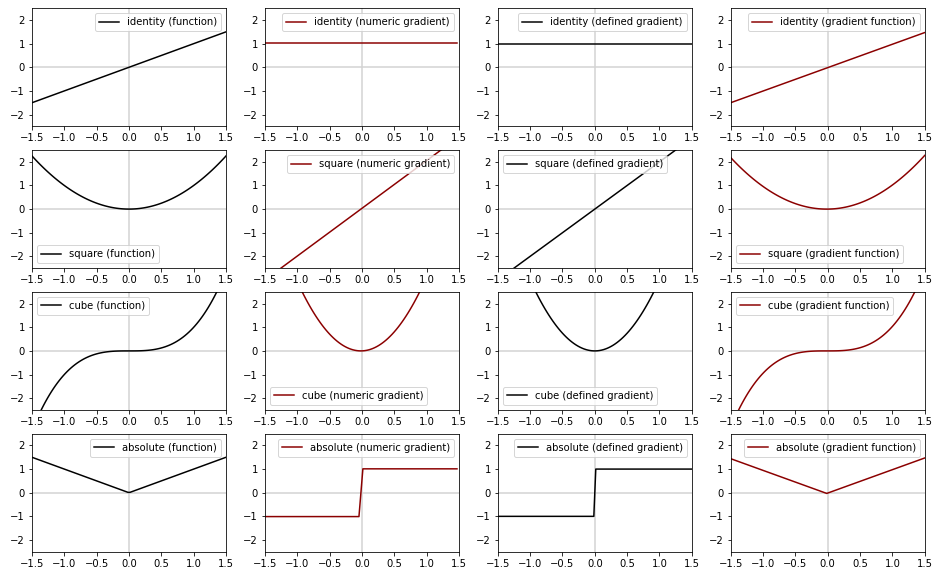

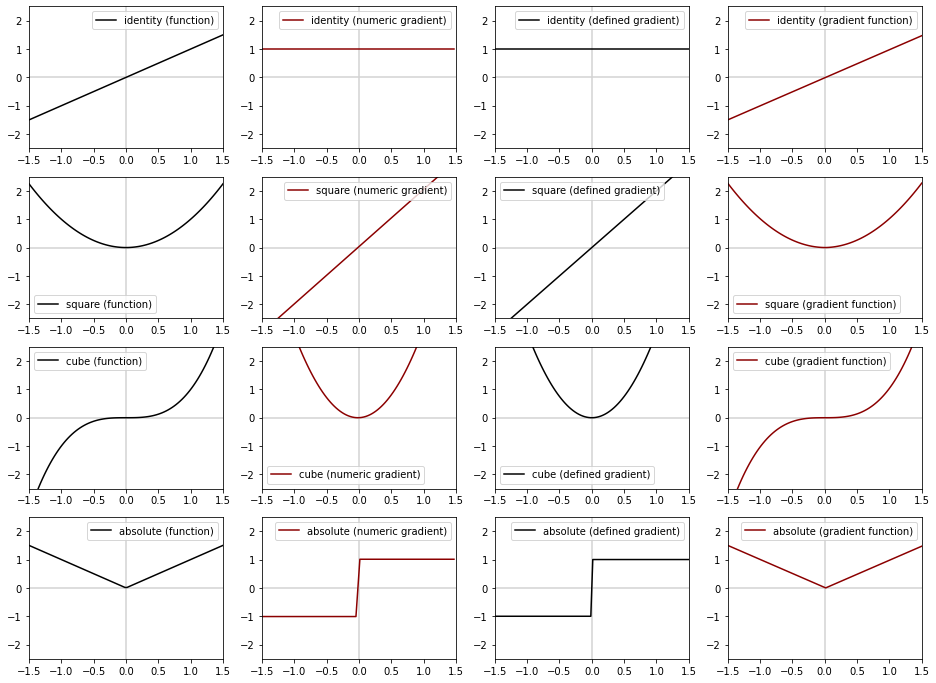

In [3]:
from typing import List, Callable
        
import numpy as np
import matplotlib.pyplot as plt
import torch


def calculate_numeric_gradient(x_values: np.array, y_values: np.array, x_step_size: float):
    # :param x_values: a list of equidistant x values
    # :param y_values: the list of corresponding y values for an unknown function
    # :param x_step_size: the fixed distance between two consecutive x values
    # :return: a list of numeric gradients for each step in the function (with one less element than the given x_values)

    # initialize a numpy array with the correct size
    numeric_gradient = np.zeros(len(x_values) - 1)

    # TODO: calculate the numeric gradient between each consecutive pair of x values based on the given y values
    # TASK START - Start coding here:
    y_values_shifted = y_values[1:]
    numeric_gradient = numeric_gradient + (y_values_shifted - y_values[0:-1])/x_step_size
    
    return numeric_gradient


def reconstruct_gradient_function(x_grad_values: np.array, x_step_size: float):
    # :param x_grad_values: a list of calculated gradients (based on step size `x_step_size`)
    # :param x_step_size: the distance between two consecutive x values that was used to calculate `x_grad_values`
    # :return: a list of y values for a (representative) function that would create the given gradient values
    #          (the y_values should be zero at the middle element)

    # intialize an array with the correct size
    y_values = np.zeros(len(x_grad_values))

    # TODO: construct a list of y values for a (representative) function that would create the given gradient values
    # HINT: start with any arbitrary value, create y_values step by step, finally subtract something from all values so the middle element becomes zero
    # TASK START - Start coding here:
    delta_y = x_grad_values * x_step_size
    i_central = int(len(x_grad_values)/2)
    for i in range(1, i_central):
        y_values[i_central + i] = y_values[i_central + i - 1] + delta_y[i_central + i]
        y_values[i_central - i] = y_values[i_central - i + 1] - delta_y[i_central - i]  
        
    y_values[0] = y_values[1] - delta_y[0]
    
    return y_values

def plot_functions(functions_to_plot: List[Callable[[torch.tensor], torch.tensor]], xlim = (-1.5, 1.5), ylim = (-2.5, 2.5), steps = 100):
    x_values = np.linspace(*xlim, steps)
    x_step_size = (xlim[1] - xlim[0]) / steps
    fig, axes = plt.subplots(len(functions_to_plot), 4, figsize=(16, len(functions_to_plot) * 3), subplot_kw={"ylim": ylim, "xlim": xlim})
    if len(functions_to_plot) == 1:
        axes = [axes]
    # create the actual plot
    for fn, axes_per_function in zip(functions_to_plot, axes):
        x = torch.tensor(x_values, requires_grad=True)
        y = fn(x)
        y.sum().backward()

        y_values = y.detach().numpy()
        
        numeric_gradient = calculate_numeric_gradient(x_values, y_values, x_step_size)
        numeric_grad_function = reconstruct_gradient_function(x.grad, x_step_size)

        axes_per_function[0].plot(x_values,      y_values,              label=f"{fn.__name__} (function)",           color="black")
        axes_per_function[1].plot(x_values[:-1], numeric_gradient,      label=f"{fn.__name__} (numeric gradient)",  color="darkred")
        axes_per_function[2].plot(x_values,      x.grad,                label=f"{fn.__name__} (defined gradient)",   color="black")
        axes_per_function[3].plot(x_values,      numeric_grad_function, label=f"{fn.__name__} (gradient function)", color="darkred")
        #axes_per_function[0].plot(x_values,      numeric_grad_function, label=f"{fn.__name__} (gradient function)", color="darkred", linestyle='dashed')
        
        for axis in axes_per_function:
            axis.axvline(x=0, c="lightgrey", zorder=0)
            axis.axhline(y=0, c="lightgrey", zorder=0)
            axis.legend()

    plt.show()


def identity(x: torch.tensor):
    return x

def square(x: torch.tensor):
    return x * x

def cube(x: torch.tensor):
    return x * x * x

def absolute(x: torch.tensor):
    return x.abs()


plot_functions([identity, square, cube, absolute])

If you are done, check your output with the provided example above.

Next, we are going to visualize the `sign` function (which we used in the simple toy example) with our new code:

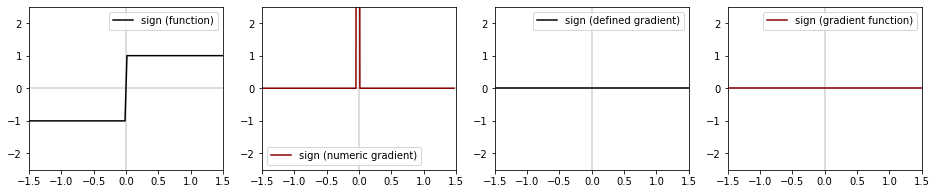

In [4]:
def sign(x: torch.tensor):
    return x.sign()

plot_functions([sign])

As we can see, the gradient of the sign function is 0 everywhere.
This is not useful at all for the optimization and it explains why the weights were not updated in our toy example as well.
All gradients propagated through any `sign` function become zero!
Therefore, we need to implement a version of the sign function that uses a so called Straight Through Estimator in the next step, fixing this problem.

# Task 2: Implement the Sign Function with Straight Through Estimator

Now we need to define the sign quantization function that actually allows our network to learn.
To do so, we are going to use a trick named Straight Through Estimator (STE).
In this case, in the **backward** pass we "pretend" that we only used a linear function during the **forward** pass.
But actually, we apply the sign function in the forward pass (but we set all zeros to one).

However, we also do not want that our weights and features before the `sign` function become very large.
Since the `sign` function only depends on the sign and not the absolute value, Hubara et al. suggested clipping the **gradients** (in the backward pass) if the corresponding **input values** are smaller than -1 or larger than +1.
They also suggest clipping the weights in the same way.

Later research work has shown that it can be useful to vary this threshold, e.g. using +1.25 and -1.25 instead, so we are going to use a variable for this threshold.

There are (at least) two options to solve this task:

- 2a) implement a custom operator (i.e. fill out `DifferentiableSignFunction`) where you can define the forward and backward pass explicitely
- 2b) implement a sign function with STE by manipulating the computational graph with the `.detach()` function (you probably remember this function from the knowledge distillation lesson)

You can implement both versions, however only one is required.
Thus if you do not want to spend too much time, we suggest you  only implement one version and we think the first option might be a bit easier than the second.

In [5]:
from torch.nn import Module
from torch.autograd.function import Function

class DifferentiableSignFunction(Function):
    
    @staticmethod
    def forward(ctx, input_tensor, gradient_clipping_threshold):
        ctx.save_for_backward(input_tensor, torch.tensor(gradient_clipping_threshold, device=input_tensor.device, dtype=input_tensor.dtype))

        # Task 2a) - Forward
        # TODO: implement the forward pass of the sign function (remember this function should not return 0, instead all 0s should become 1)
        # TASK START - Start coding here:
        fwd = input_tensor.sign()
        fwd[fwd == 0] = 1.0
        return fwd
    
    @staticmethod
    def backward(ctx, output_gradient):
        input_tensor, gradient_cancellation_threshold = ctx.saved_tensors

        # Task 2a) - Backward
        # TODO: implement the straight through estimator backward pass
        # HINTs: 
        #     1) set the gradients (of output_gradient) to zero where the values of the input tensor are outside the range of [-theshold, threshold]
        #     2) since two input values were passed to the forward function, the backward function expects two return values
        #        but the second value would be the gradient for the cancellation threshold (which is a constant), you can return None
        # TASK START - Start coding here:
        grad_tensor = torch.zeros(input_tensor.shape)
        inside_range = ((input_tensor >= - gradient_cancellation_threshold) & 
                        (input_tensor <= gradient_cancellation_threshold))
        grad_tensor[inside_range] = 1
        
        return grad_tensor, None
        # HINT: the last line should look like this (of course you should use your own variable name):
        # return gradients_cancelled, None


def differentiable_sign_function(input_tensor, gradient_cancellation_threshold):
    # Task 2b)
    # TODO: implement a sign function where you manipulate the computational graph (remember this function should not return 0, instead all 0s should become 1)
    # HINTs: 
    #     1) to replace the backward pass of one part of the computational graph (attached to tensor a) with another one (attached to tensor b)
    #        we can compute: (a - b).detach() + b
    #        during the forward pass the result is a but during the backward pass (a - b) is removed from the graph, so the backward pass is only based on b
    # TASK START - Start coding here:
    #raise NotImplementedError()
    # TASK END
    return None


class SignQuantization(Module):
    def __init__(self, gradient_clipping_threshold=1.0):
        super().__init__()
        self.gradient_clipping_threshold = gradient_clipping_threshold
    
    def forward(self, input_tensor):
        sign_solution_b = differentiable_sign_function(input_tensor, self.gradient_clipping_threshold)
        if sign_solution_b is not None:
            return sign_solution_b
        return DifferentiableSignFunction.apply(input_tensor, self.gradient_clipping_threshold)

Now you can visualize your implemented solution to check if the forward and backward passes are correct. Your implementation should be correct if your output looks like the picture below:

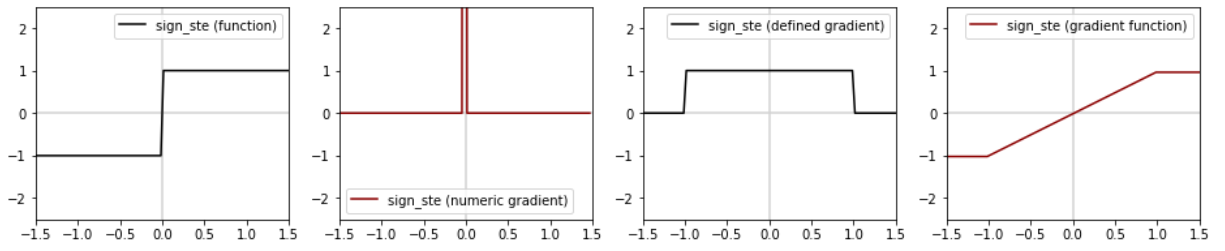

Once your function visualization looks correct, you can now compare it to our other functions above (you can add them in the graph below if you want).
The numeric gradient still ist not useful for learning, but that gradient is not actually used by the network.
Instead our defined gradient is used and now allows the network to learn.
Finally, our (reconstructed) *gradient function* gives us an idea, of how the framework "sees" the function used in the **backward** pass.
It looks a little bit similar to the original *sign* function for x values smaller than -1 and larger than 1 and allows learning in between. 

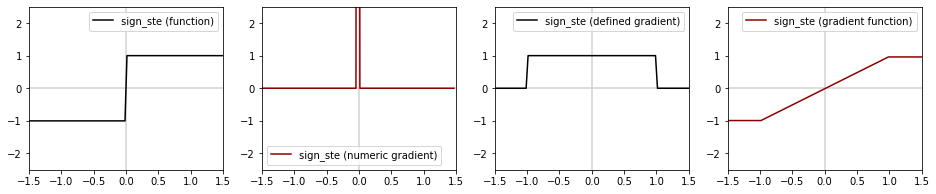

In [6]:
def sign_ste(x: torch.tensor):
    return SignQuantization()(x)

plot_functions([sign_ste])


Another test you can do is to check whether the following numeric assertions hold true.
In this case we are also testing that gradients can be passed through our function (by asserting that `torch.allclose(expected_gradient, test_data.grad)` is true).

If you want you can also try to adapt our initial toy example and you are going to see that the 32-bit weights are now updated if we use our new `sign_quantization` function.

In [7]:
sign_quantization = SignQuantization()

test_data = torch.tensor([-3, -2, -1, 0, 1, 2, 3], requires_grad=True, dtype=torch.float)
expected_result = torch.tensor([-1, -1, -1, 1, 1, 1, 1], dtype=torch.float)
expected_gradient = torch.tensor([0, 0, 1, 1, 1, 0, 0], dtype=torch.float)

result = sign_quantization(test_data)
assert torch.allclose(expected_result, result.detach())

loss = result.sum()
loss.backward()
assert torch.allclose(expected_gradient, test_data.grad)
print("Test passed.")

Test passed.


## Reusing Code

Now that we have understood how we can implement a `sign` function that allows us to train a binary neural network, we can move to building a whole binary network.
But before we start, we can reuse parts of our previous code here for the data loading and define some imports needed later on (similar to our previous exercises).
We already added this code in the following cells, you do not need to change the code in the following cell.

In [8]:
import math
import pickle
import statistics

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import imgaug

from collections import defaultdict
from typing import Type, List, Union

from imgaug import augmenters as iaa
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm, trange
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler, OneCycleLR
from torch.utils.data import DataLoader, Dataset


class CIFAR100(Dataset):
    
    def __init__(self, dataset_path: Path, image_transforms: tt.Compose, image_augmentations: Union[None, Type[iaa.Augmenter]] = None):
        super().__init__()
        data = pickle.load(dataset_path.open("rb"), encoding="bytes")
        self.images = data[b"data"]
        self.labels = data[b"fine_labels"]
        
        self.image_transforms = image_transforms
        self.image_augmentations = image_augmentations
        
        assert len(self.images) == len(self.labels), "Number of images and labels is not equal!"
        
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self, index: int) -> tuple:
        image = self.images[index]
        label = self.labels[index]
        
        image = np.reshape(image, (3, 32, 32))
        image = np.transpose(image, (1, 2, 0))
        
        if self.image_augmentations is not None:
            image = self.image_augmentations.augment_image(image)
        image = self.image_transforms(Image.fromarray(image))
        return image, label
    

image_transformations = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(
        mean=(0.5074, 0.4867, 0.4411),
        std=(0.2011, 0.1987, 0.2025)
    )
])

train_augmentations = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.CropAndPad(px=(-4, 4), pad_mode="reflect")
])

    
def accuracy(predictions: torch.Tensor, labels: torch.Tensor, reduce_mean: bool = True) -> torch.Tensor:
    predicted_classes = torch.argmax(F.softmax(predictions, dim=1), dim=1)
    correct_predictions = torch.sum(predicted_classes == labels)
    if reduce_mean:
        return correct_predictions / len(labels)
    return correct_predictions


def test_model(network: Type[nn.Module], data_loader: DataLoader) -> float:
    num_correct_predictions = 0
    device = get_device()
    
    for images, labels in data_loader:
        images = to_device(images, device)
        labels = to_device(labels, device)
        predictions = network(images)
        num_correct_predictions += float(accuracy(predictions, labels, reduce_mean=False).item())
        
    return num_correct_predictions / len(data_loader.dataset)


def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


def to_device(data: torch.Tensor, device: torch.device) -> torch.Tensor:
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)


BATCH_SIZE = 128
train_dataset = CIFAR100(Path("/kaggle/input/cifar100/train"), image_transformations, train_augmentations)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

test_dataset = CIFAR100(Path("/kaggle/input/cifar100/test"), image_transformations)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

## Installing BITorch

To further simplify the implementation, we want to use the [BITorch](https://github.com/hpi-xnor/bitorch) library, which provides binarized and quantized versions of most common layers used in Convolutional Neural Networks.
Otherwise we would need to implement our own custom convolutions and linear (dense) layers.

To allow installation of packages, you need to have *your phone number verified* [in your Kaggle profile](https://www.kaggle.com/me/account). Then you can enable the Internet switch in the sidebar on the right (you can open the sidebar by clicking on the |< Symbol in the top right, then select Settings, Internet). The switch should show a checkmark afterwards.

In [9]:
!pip install bitorch torchinfo

     |████████████████████████████████| 70 kB 658 kB/s            


# Task 3: Defining the Binary Neural Network

Now we are going to define a binary neural network for the Cifar100 dataset. For this we will be utilizing the same network architecture as in the past weeks, Resnet, but we will replace the basic building block, which is the key part of Resnets architecture, with a binarized version of it. The following picture visualizes the structure of the full precision (32 bit) version of the Resnet building Block (source of the illustration made by Arden Stiedemann: https://morioh.com/p/18a0e3c6e6c2):

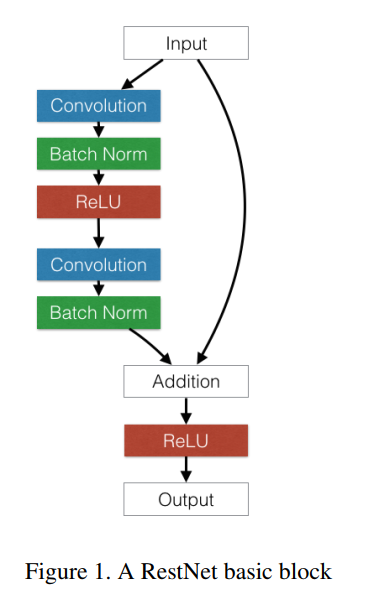

For this task, it makes sense to first have a look at the 32-bit implementation of the `BasicBlock` of the [feature extractors](https://www.kaggle.com/bartzi/cifar100-resnets) which we used over the past weeks.
Your task is to define a `BinaryBasicBlock` module based on the `BasicBlock` module with the following two changes:

1. Replace the 32-bit Convolution layers with their 1-bit version
2. Remove the ReLU layers during the forward implementation

## Task 3a): Replace the 32-bit Convolution layers with their 1-bit version

First, we need to adapt the two convolutional layers to use binarized convolutions instead.
For this task, we can use the `QConv` layers from [BITorch](https://github.com/hpi-xnor/bitorch).
These quantized convolutional layers take the same parameters as a conventional `Conv` Layer from pytorch, but add additional options to quantize the input values and the weights before doing the actual convolution operation.
Furthermore, we typically use `bias=False` for binarized layers.

So if we want to convert, for example, the 32-bit convolution layer
```
Conv2d(3, 16, kernel_size=3)
```
to a binary version using only 1 bit, we should use `QConv2d` instead, pass `"sign"` as the quantization methods, and add `bias=False`:
```
QConv2d(3, 16, kernel_size=3, bias=False, input_quantization="sign", weight_quantization="sign")
```

For a full list of supported quantization functions, you can call `bitorch.quantizations.quantization_names()`.
However for this task the "sign" quantization function should be used.

## Task 3b): Remove the ReLU layers during the forward implementation

Secondly, we need to remove the ReLU layers. Do you already know why?

If you remember the definition of a ReLU layer: it sets all negative values to zero.
This is not very useful for our BNN, since we want to use the *sign* quantization throughout the network to quantize the inputs.
And the *sign* function for BNNs returns +1 for all values larger than or equal to zero.
Thus, a ReLU layer will remove a lot (if not all) information from the feature map for a binary convolution following the ReLU layer (the whole feature map will be only +1s).

Therefore, we should remove it.
(There are alternatives, such as moving the positioning of the ReLU layer to a position directly before a BatchNorm layer, but for our CIFAR100 model it is easier to simply remove it.)

In [10]:
from cifar100_resnets import BasicBlock, ResNet
from bitorch.layers import QConv2d

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BinaryBasicBlock(BasicBlock):
    def __init__(self, input_planes, output_planes, stride, option='A'):
        super().__init__(input_planes, output_planes, stride)
        # Task 3a)
        # TODO: overwrite the two convolutional layers of BasicBlock with their binary versions (use "sign" to quantize inputs and weights and disable the bias)
        #       (check https://www.kaggle.com/bartzi/cifar100-resnets to see how they defined in the original implementation)
        # HINT: 1) this (only) concerns the properties `self.conv1` and `self.conv2` of this class
        #       2) the binarized QConv2d layers should have the same number of input planes, output planes, stride and padding as their 32-bit version but no bias
        #          and have input_quantization and weight_quantization set to "sign" to binarize both inputs and weights
        # TASK START - Start coding here:
        super(BasicBlock, self).__init__()
        self.conv1 = QConv2d(input_planes, output_planes, kernel_size=3,stride=stride, padding=1, bias=False, input_quantization='sign', weight_quantization='sign')
        self.bn1 = nn.BatchNorm2d(output_planes)
        self.conv2 = QConv2d(output_planes, output_planes, kernel_size=3, stride=1, padding=1, bias=False, input_quantization='sign', weight_quantization='sign')
        self.bn2 = nn.BatchNorm2d(output_planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or input_planes != output_planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, output_planes//4, output_planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     QConv2d(input_planes, self.expansion * output_planes, kernel_size=1, stride=stride, bias=False, input_quantization='sign', weight_quantization='sign'),
                     nn.BatchNorm2d(self.expansion * output_planes)
                )

    def forward(self, x):
        # Task 3b)
        # TODO: copy the forward function from the original implementation and remove all calls to F.relu
        #       (check https://www.kaggle.com/bartzi/cifar100-resnets to see the original implementation)
        # TASK START - Start coding here:
        out = self.bn1(self.conv1(x))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return out


class ResNet20(ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [3, 3, 3], num_classes=100)


class BinaryResNet20(ResNet):
    def __init__(self):
        super().__init__(BinaryBasicBlock, [3, 3, 3], num_classes=100)

After implementing this, we can perform a basic check of our implementation by visualizing both models and comparing them.

## Visualize the 32-bit model

Now, if we check the model summaries of the full precision and binary version of resnet, you should see a significant drop in model size, since most of the trainable parameters of the model are now quantized.

To do so, lets first print a summary of the 32-bit model:

In [11]:
from torchinfo import summary as summary_32bit

print(summary_32bit(ResNet20(), input_size=(1, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet20                                 --                        --
├─Conv2d: 1-1                            [1, 16, 32, 32]           432
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─Sequential: 1-3                        [1, 16, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─Conv2d: 3-3                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-4             [1, 16, 32, 32]           32
│    │    └─Sequential: 3-5              [1, 16, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    

## Visualize the 1-bit model

Now, we can also run the same code, but based on [bitorchinfo](https://github.com/hpi-xnor/bitorchinfo), which is an extended version of [torchinfo](https://github.com/TylerYep/torchinfo) to support the binary layers of [bitorch](https://github.com/hpi-xnor/bitorch), to visualize our binarized model.

In [12]:
from bitorchinfo import summary as summary_1bit
from bitorch.quantizations import Quantization

print(summary_1bit(BinaryResNet20(), input_size=(1, 3, 32, 32), quantization_base_class=Quantization))

Layer (type:depth-idx)                   Output Shape              Param #
BinaryResNet20                           --                        --
├─Conv2d: 1-1                            [1, 16, 32, 32]           432
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─Sequential: 1-3                        [1, 16, 32, 32]           --
│    └─BinaryBasicBlock: 2-1             [1, 16, 32, 32]           --
│    │    └─QConv: 3-1                   [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─QConv: 3-3                   [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-4             [1, 16, 32, 32]           32
│    │    └─Sequential: 3-5              [1, 16, 32, 32]           --
│    └─BinaryBasicBlock: 2-2             [1, 16, 32, 32]           --
│    │    └─QConv: 3-6                   [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    

## Comparing both models

It makes sense to make sure that the output shapes of both models are equal for a given layer (and all `BinaryBasicBlocks` use `QConv2d` instead of `Conv2d` layers).
If this is the case, it is a good sign, that our binary model is implemented correctly.

When carefully checking the output above you should also be able to see, that two layers *should remain* in 32-bit: the very first `Conv2d` layer and the final `Linear` layer.
This is not a mistake: these layers are usually **not** quantized/binarized, since they only account for a small number of parameters and operations and keeping them in 32-bit helps to keep the accuracy of the model high.

The parameters of the model should consist of 8,308 full precision (32-bit) parameters and 267,264 quantized parameters, and the model should have an estimated total size of 1.76 MB.
The computations should consist of 0.45 million full precision (32-bit) mult-adds and 40.11 million quantized mult-adds.

Also, double check whether you removed all calls to `F.relu` in the forward implementation, as these are not shown in the tabular overview. Otherwise the model performance is not going to be very good.

# Train the Binary Model

Now, we just need to perform the last setup steps and then start the training. \O/

Before starting the training below, you should enable the GPU acclerator in the sidebar on the right (you can open the sidebar by clicking on the |< Symbol in the top right, then select *Settings*, *Accelerator*, *GPU*).

If you have not done so at the beginning of working on this exercise (which is fine), this means the other cells need to be run again.
To do so, you can select *Run All* in the top toolbar.
The notebook should run most of the previous cells very quickly until the training below is executed.

In [13]:
loss_function = nn.CrossEntropyLoss()

def train_for_one_iteration(network: Type[nn.Module], batch: tuple, optimizer: Type[Optimizer]) -> float:
    images, labels = batch
    predictions = network(images)
    loss = loss_function(predictions, labels)
    
    # Here come the real weight adjustments, first zero gradients, then calculate derivatives, followed by the actual update of the optimizer
    optimizer.zero_grad()  # this sets gradients to zero (e.g. to clean up from any previous backward passes)
    loss.backward()        # calculate gradients for our network
    optimizer.step()       # update all weights in our network according to the computed gradients
    
    return float(loss.item())

def train(train_data: DataLoader, test_data: DataLoader, network: Type[nn.Module], optimizer: Type[Optimizer], \
          lr_scheduler: Type[_LRScheduler], num_epochs: int) -> dict:
    device = get_device()
    metrics = defaultdict(list)
    for epoch in trange(num_epochs, desc="Epoch: "):
        losses = []
        with tqdm(total=len(train_data), desc="Iteration: ") as progress_bar:
            for iteration, batch in enumerate(train_data):
                batch = to_device(batch, device)
                loss = train_for_one_iteration(network, batch, optimizer)
                losses.append(loss)

                current_iteration = epoch * len(train_data) + iteration
                metrics["loss"].append({"iteration": current_iteration, "value": loss})
                current_learning_rate = lr_scheduler.get_last_lr()[0]
                metrics["learning_rate"].append({"iteration": current_iteration, "value": current_learning_rate})

                progress_bar.set_postfix({"lr": f"{current_learning_rate:.6f}"})
                progress_bar.update()
                lr_scheduler.step()

            accuracy = test_model(network, test_data)
            current_iteration = (epoch + 1) * (len(train_data))
            metrics['mean_loss'].append({"iteration": current_iteration, "value": statistics.mean(losses)})
            metrics['accuracy'].append({"iteration": current_iteration, "value": accuracy})
            progress_bar.set_postfix_str(f"Epoch {epoch}, Mean Loss: {statistics.mean(losses):.2f}, Test Accuracy: {accuracy:.2f}")

    return metrics

learning_rate = 0.01
num_epochs = 50

# create our binary ResNet and move it to GPU
network = BinaryResNet20()
network = network.to(get_device())

# create an optimizer for training, for BNNs it was shown, that Adam usually performs better than SGD
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
lr_scheduler = OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=len(train_data_loader))

# we are done with all setup and can start the training
logged_metrics = train(train_data_loader, test_data_loader, network, optimizer, lr_scheduler, num_epochs)

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

After training for 50 epochs, the model should achieve an accuracy of about 45%.
In general, converting a 32-bit model to a BNN model should allow us to achieve a similar accuracy with the binary model compared to the 32-bit model, but it usually is slightly lower (between 1 and 10%, depending on the task).
Of course this can depend on the hyperparameters and the optimizer choice, but in general binary networks are less representative and thus slightly less accurate than 32-bit networks.

An exception is if the 32-bit model is highly overfitting on the training data (and both models achieve close to 100% training accuracy): in this case a binary model could achieve higher test accuracy, but this is a special case and not very common.

## Plotting of Progress

As in the last exercise, we can now plot the train progress using the `plot_metrics` function:

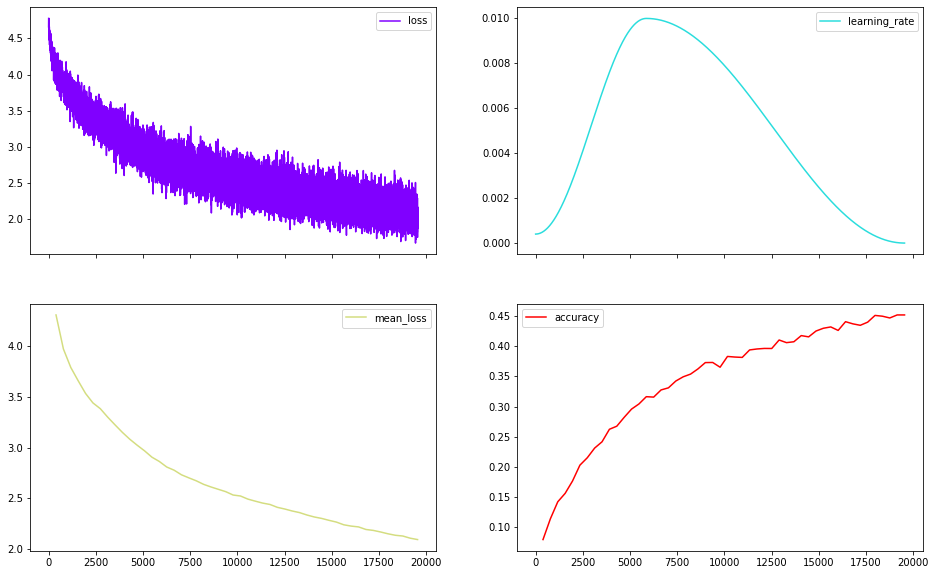

In [14]:
def plot_metrics(metrics: dict):
    # we prepare the plotting by creating a set of axes for plotting, we want to put each metric in its own plot in a separate row
    # furthermore, all plots should share the same x-axis values
    fig, axes = plt.subplots(math.ceil(len(metrics) / 2), 2, sharex=True, figsize=(16, 10))

    # we want to have a set of distinct colors for each logged metric
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(metrics))))
    
    # create the actual plot
    for (metric_name, metric_values), axis in zip(metrics.items(), axes.flatten()):
        iterations = []
        values = []
        for logged_value in metric_values:
            iterations.append(logged_value["iteration"])
            values.append(logged_value["value"])
        axis.plot(iterations, values, label=metric_name, color=next(colors))
        axis.legend()
    plt.show()

    
plot_metrics(logged_metrics)

# What Now?

Similar to the previous weeks, you should keep in mind what you just did in this exercise, as we will ask about the implementation in the graded test.

We also want to offer further ideas you can explore:

You can check [the paper](https://arxiv.org/abs/1602.02830) of Hubara et al. and try to implement the stochastic option of the sign function.

You can try to train a quantized model that uses 4 bit instead of 1 bit.

For this you can use the functions `weightdorefa` and `inputdorefa` and set the number of bits in the `config` as shown below:
```
import bitorch.quantization.config as QuantizationConfig
QuantizationConfig.dorefa_bits = 4
# now we can use "weightdorefa" and "inputdorefa" as arguments to QConv2d and they will use 4 bits
```

You could also try to visualize these quantization functions for e.g., 2, 3, or 4 bits using the visualization you implemented in task 1 to understand how weights and activations are quantized to other bit-widths.
```
from bitorch.quantization import WeightDoReFa
w_dorefa = WeightDoReFa(bits=4)
# now we can pass some data through w_dorefa with forward
y = w_dorefa.forward(x)
```

Finally, you can also try to understand how the `QConv2d` layer we used is actually implemented in [BITorch](https://github.com/hpi-xnor/bitorch/blob/main/bitorch/layers/qconv.py).